Goal: Predict HP as a function of other fighting stats for Pokemon.

First we import packages and the data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection, linear_model
import operator

seed=6291

records=pd.read_csv('Data/Pokemon_stats.csv')

records.head()




,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [2]:
print("Number of Pokemon: " + str(records.shape[0]))
print(records.describe())

Number of Pokemon: 800
                #      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.

We see here that there are 800 Pokemon in this dataset and all of them have numerical data in each stat column. We do not have to do any data cleaning for N/As.

Let's see what the data looks like. Since there are only a few columns, I'm using the pairplot to see individual field value distribution and how the features interact with each other.

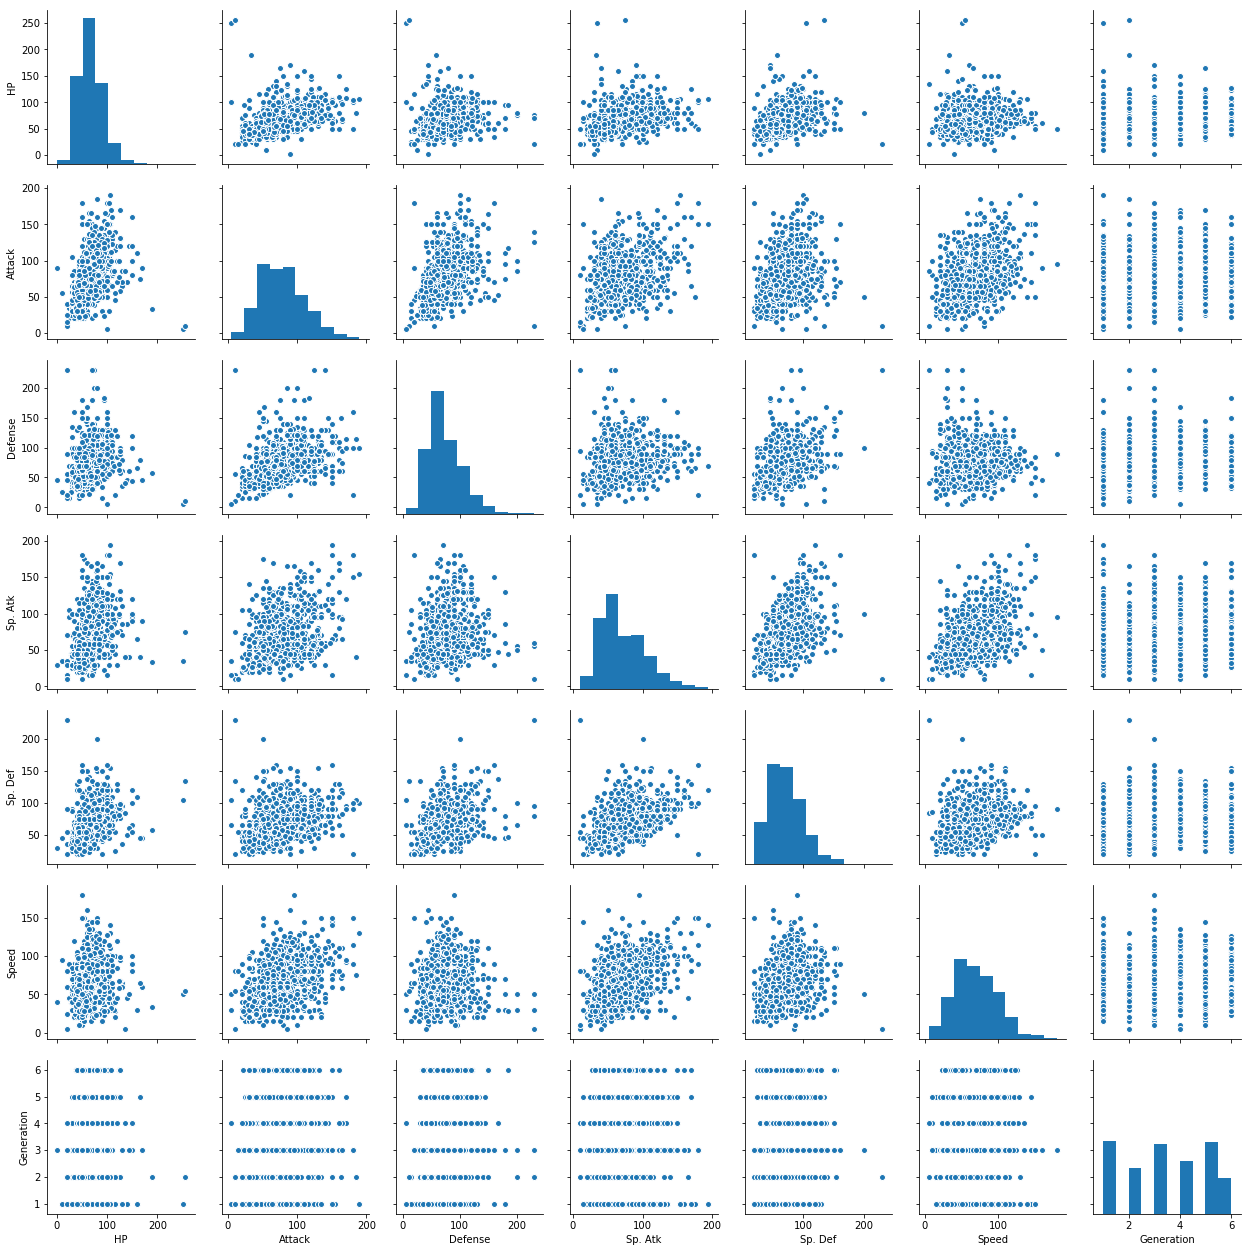

In [3]:
sns.pairplot(records.drop(['#', 'Total', 'Legendary'], axis=1))

Attack and Defense seem to be relatively correlated, as well as Sp. Attack and Sp. Defense. There also seems to be a general skewness to the right over all features. This might be due to any legendary Pokemon in the data set. Just to be safe, let's remove them going foward.

Number of Pokemon: 735


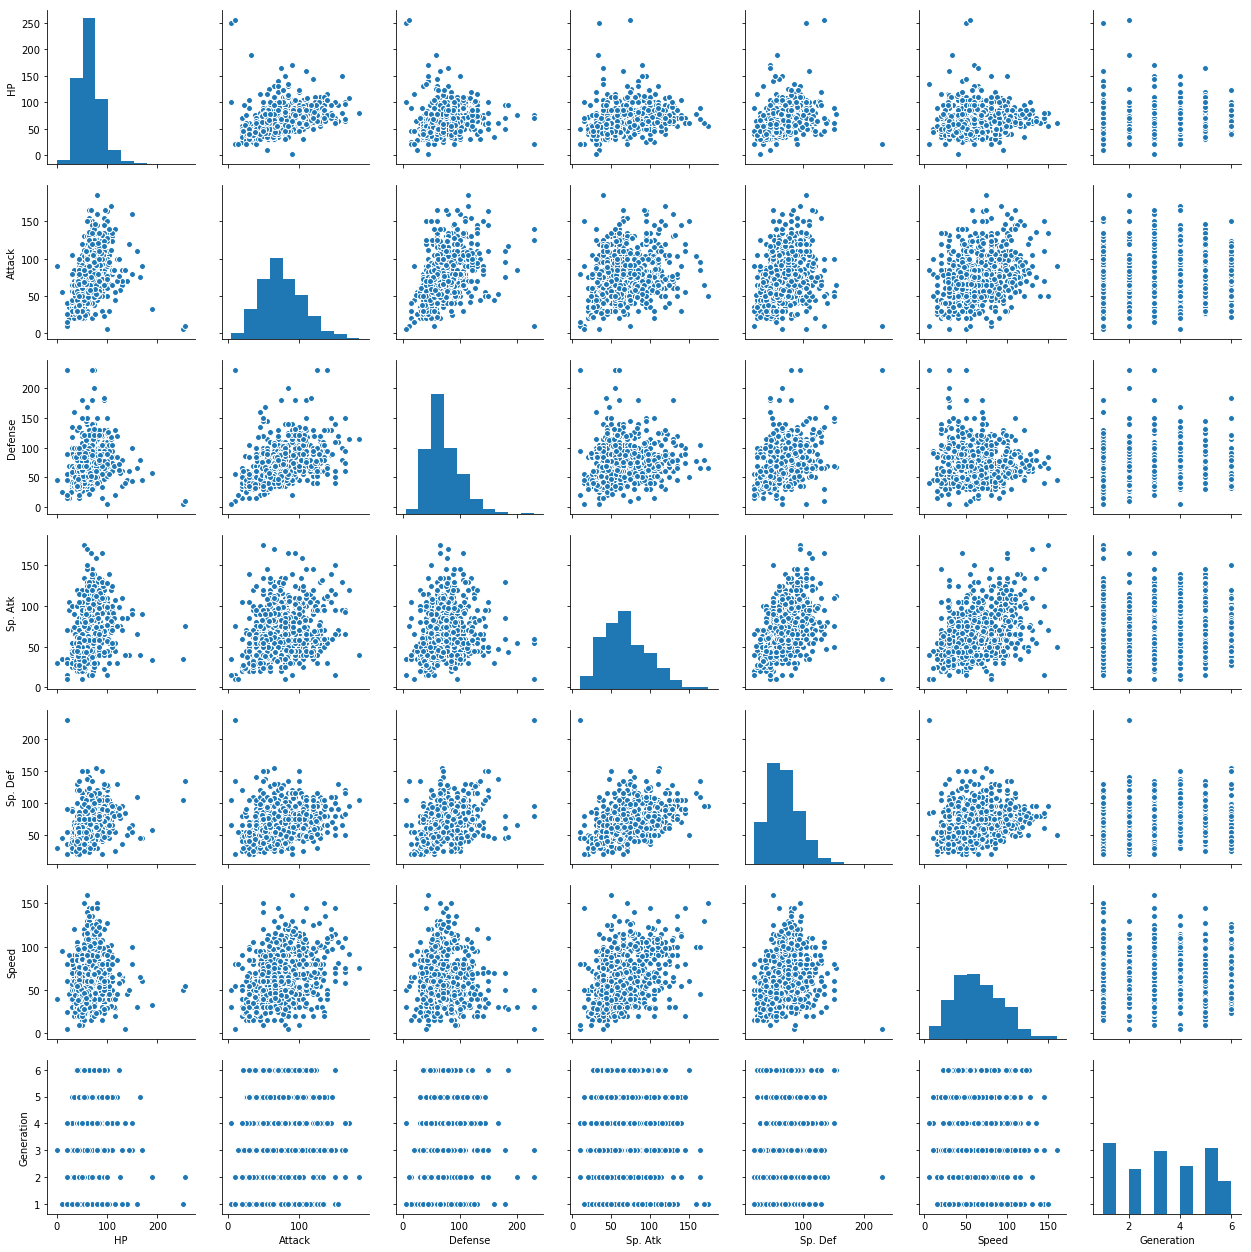

In [5]:
records_noleg=records[records['Legendary']==False]
print("Number of Pokemon: " + str(records_noleg.shape[0]))
sns.pairplot(records_noleg.drop(['#', 'Total', 'Legendary'], axis=1))

Ok there is still some skewness. There are also "Mega" pokemon in the data with boosted stats. Let's start from scratch and remove the "Mega" Pokemon.

Number of Pokemon: 752


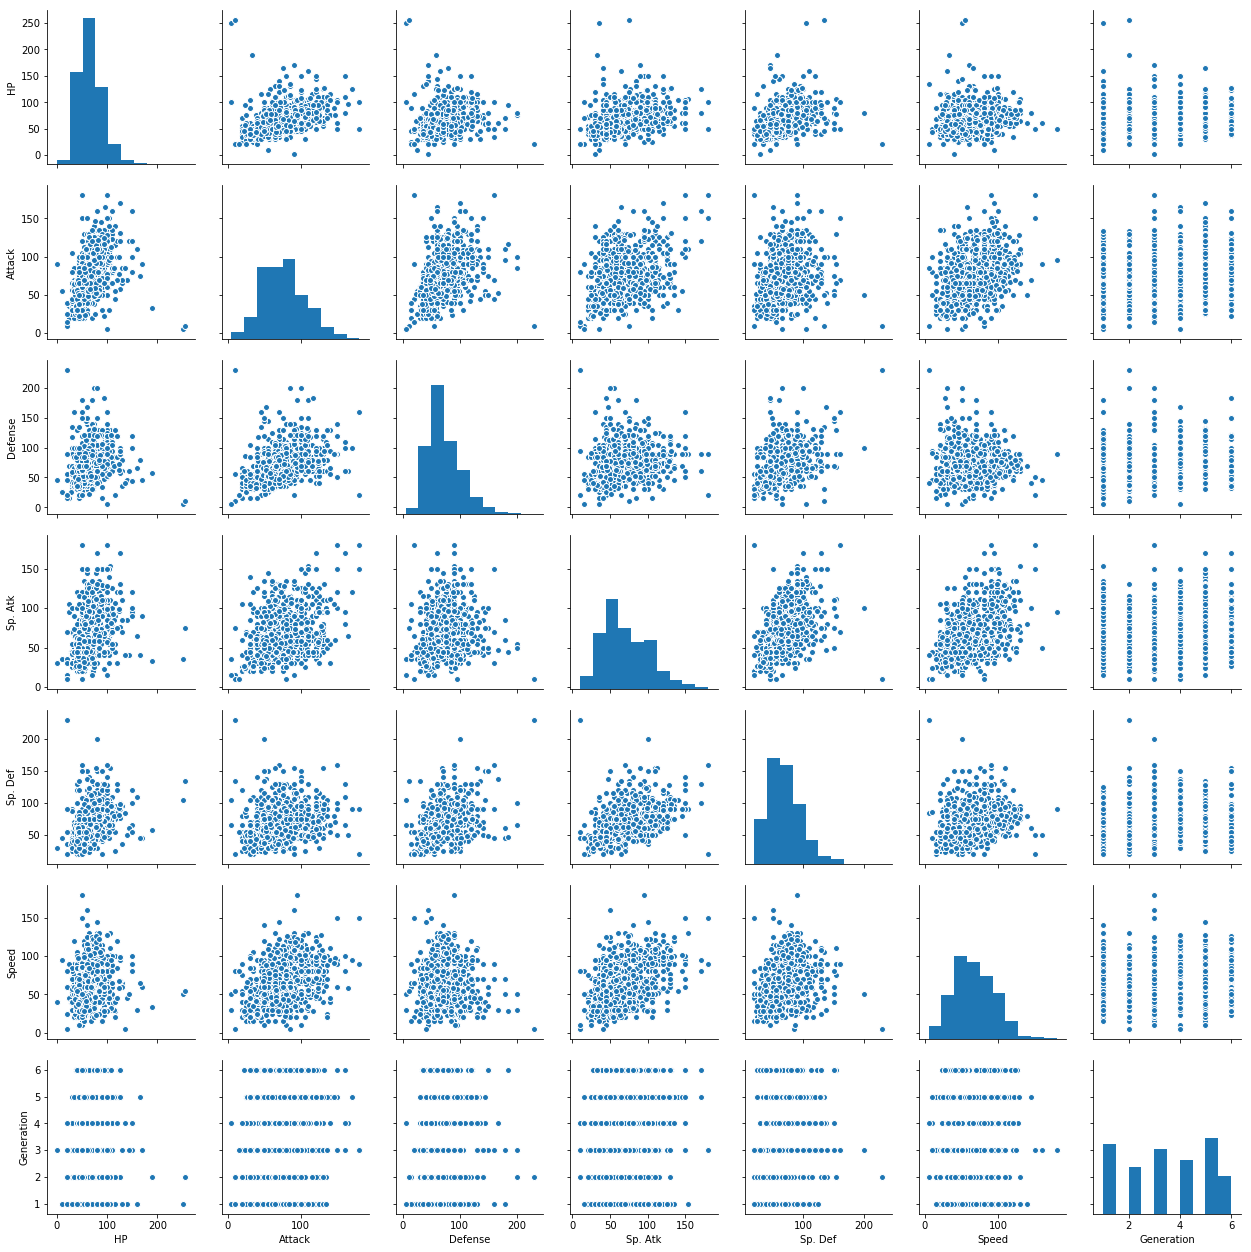

In [7]:
records_noMega=records[~records['Name'].str.contains("Mega ")]
print("Number of Pokemon: " + str(records_noMega.shape[0]))
sns.pairplot(records_noMega.drop(['#', 'Total', 'Legendary'], axis=1))

There is still some right skewness, so neither the "Legendaries" nor the "Megas" were the source of the issue. I will keep the Megas removed however, because they are just beefed up versions of the normal Pokemon.

Since it doesn't make sense to get rid of more data right now, I will transform the data using the logistic function to create a normalized data set. Why? The predictive model I want to use depends on the data being normalized. The logistic function will work fine since the data is all greater than zero. I'm also removing columns we don't need to use to create the model.


         HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  Generation
0  3.806662  3.891820  3.891820  4.174387  4.174387  3.806662         0.0
1  4.094345  4.127134  4.143135  4.382027  4.382027  4.094345         0.0
2  4.382027  4.406719  4.418841  4.605170  4.605170  4.382027         0.0
4  3.663562  3.951244  3.761200  4.094345  3.912023  4.174387         0.0
5  4.060443  4.158883  4.060443  4.382027  4.174387  4.382027         0.0


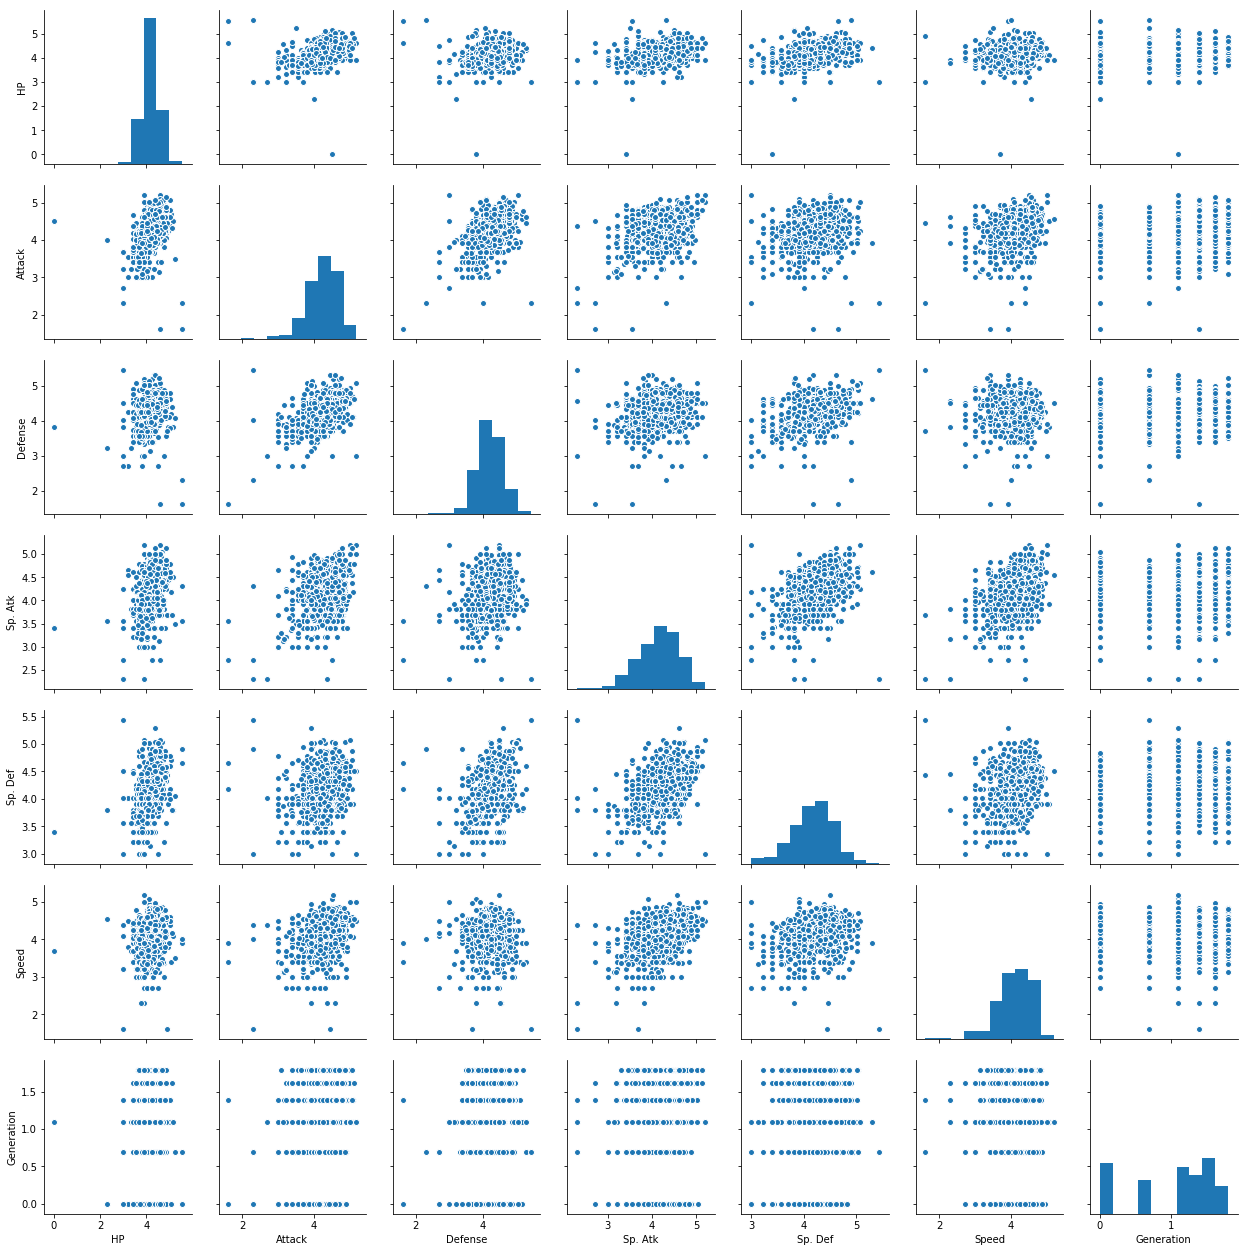

In [35]:
stats_log=records_noMega.drop(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'Legendary'], axis=1).apply(np.log, axis=1)
print(stats_log.head())
sns.pairplot(stats_log)

Since we still have a good chunk of data here, let's split the dataset up into 3 parts. One (20%) will be used for feature selection. One (~65%) will be used for training the model. And the last (15%) will be used for testing the model.

In [36]:
#create index to randomly separate out the different data sets.
stats_log=stats_log.reset_index()

#setting percentages
perc_FS=0.2
perc_train=0.65
perc_test=0.15
total_count=stats_log.shape[0]

num_FS=int(round(total_count*perc_FS,0))
num_train=int(round(total_count*perc_train,0))
num_test=int(round(total_count*perc_test, 0))

stats_FS=stats_log.sample(num_FS)
stats_train=stats_log[~stats_log.index.isin(stats_FS.index)].sample(num_train)
stats_test=stats_log[~stats_log.index.isin(stats_FS.index) & ~stats_log.index.isin(stats_train.index)]


   index        HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
0      0  3.806662  3.891820  3.891820  4.174387  4.174387  3.806662   
1      1  4.094345  4.127134  4.143135  4.382027  4.382027  4.094345   
2      2  4.382027  4.406719  4.418841  4.605170  4.605170  4.382027   
3      4  3.663562  3.951244  3.761200  4.094345  3.912023  4.174387   
4      5  4.060443  4.158883  4.060443  4.382027  4.174387  4.382027   

   Generation  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


Now let's get the dataset set aside for feature selection ready for analysis. Since there are only 6 features (Attack, Defense, Sp. Atk, Sp. Def, Speed, and Generation) that could possibly feed into HP, I won't remove any from the final model. I do, however, want to see how two types of feature selection methods rank the fields. I am also cautious of using Generation in the final model, as it does not have much variation among the Pokemon but may indeed affect HP as new generations are released. Also I think I have to take the log of every feature for a data transformation, so even though Generation wasn't skewed, I had to take the log anyway.

In [39]:

HP=stats_FS['HP'].values
stats_mtx=stats_FS.drop(['HP', 'index'], axis=1).as_matrix()
stats_names=stats_FS.columns


First feature selection method I'll use is recursive feature selection.

In [40]:
lr_stats=LinearRegression()
lr_stats.fit(stats_mtx, HP)
rfe_stats=RFE(lr_stats, n_features_to_select=1)
rfe_stats.fit(stats_mtx, HP)
print(rfe_stats.ranking_)

[1 6 2 3 4 5]


We see here that Attack (the first number in the list above) was ranked the most important feature when determining HP. Let's see what random forest selects.

In [41]:
rf_stats=RandomForestRegressor(n_estimators=50)
rf_stats.fit(stats_mtx, HP)
print(rf_stats.feature_importances_)

[ 0.47253631  0.14175767  0.14898368  0.10627955  0.09884872  0.03159406]


Random Forest also ranked Attack as the most important feature, with Special Attack being number 2.

Side note: I originally ran through this whole analysis without using log to transform the data. RFE yielded Generation as the top feature, and RF ranked Generation as the worst feature. I didn't know what to make of it. After transforming the data to help normalize the data, both feature selection methods picked Attack at the most important feature, and had similar rankings for the others. In the future, contradicting results from FS methods might be an indicator to look at the data again, possibly check for normalization.

Since I am keeping all the features, now on to the cross validation. I'm using Kfolds because it creates many models, runs the test data through it, and compiles the scores into a final output. I didn't realize until I was looking into it that Kfolds also creates training and test data sets. I continued to use the datasets I created above though because I took a slice of the data to use for feature selection. I realize while writing this that since I just used FS as an exploratory phase in the model process, I could have used all the data to divide between training and test. But I will keep it as is because I have to turn this in. Lessons learned for next time.

Since the goal of this exercise is to predict HP, we want to know how well the model does with the test data.

In [67]:

def selection_CV(model, score_type, X, Y):
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    results = model_selection.cross_val_score(model, stats_test_flt, stats_test['HP'], cv=kfold, scoring=score_type)
    model.score(X, Y)
    return ("{0}: {1}".format(score_type, results.mean()))

In [72]:
lm=linear_model.LinearRegression()
stats_train_flt=stats_train.drop(['index', 'HP'], axis=1)

model=lm.fit(stats_train_flt, stats_train['HP'])

stats_test_flt=stats_test.drop(['index', 'HP'], axis=1)

score=['explained_variance', 'r2', 'neg_mean_squared_error']
for score_txt in score:
    final=selection_CV(model, score_txt , stats_test_flt, stats_test['HP'])
    print(final)  



explained_variance: 0.278744291242755
r2: 0.14701497588463783
neg_mean_squared_error: -0.1999625920122769


Here we see that the model only explained ~28% of the variance in the data, which is pretty low. And the model didn't fit the data well, with an R^2 of 0.147 (1 is a perfect fit). The mean squared error (apparently changed to neg_mean_squared_error in the latest version of sklearn) looks ok, but I would need to create another model to compare it's MSE to in order to see if it's a good number for the data. In conjunction with the explained variance and r^2 values, I'm leaning towards it not being a great number.

Thoughts:

One possible reason the model might not explain as much variance as we would think is because of the limited range of the features and predictors in this dataset. Everything is a whole number, and there can be multiple variations of HP of 45 with different feature characteristics. The range of each of these features is also limited, so extrapolation with this model (especially in the negative direction) doesn't make sense. Next thing to try with this data is a classification selection, if a combination of stats would yeild certain Types of Pokemon with more accuracy than others. If Attack is greater than 100, does that mean it's more likely a Fighting Type rather than Grass, for example. In the mean time, gotta catch 'em all.